In [3]:
import sys
sys.path.append('../misc')
sys.path.append('../DCRNN')

from MoviaBusDataset import MoviaBusDataset
import torch
from torch.nn import Linear, Sequential, ReLU, L1Loss, LSTM, BatchNorm1d, GRU
from torch.optim import Adam, lr_scheduler
import numpy as np
import random
from BaseNetwork import BaseNetwork
from GraphConvGRU import GraphConvGRU

from lib.utils import calculate_normalized_laplacian
from data_loader import load_network, adjacency_matrix

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
prev_timesteps = 6
prediction_steps = 6
batch_size = 25

train = MoviaBusDataset('../data/train', interpolation=True, 
                        prev_timesteps=prev_timesteps, 
                        max_future_time_steps=prediction_steps
                        )
validation = MoviaBusDataset('../data/validation', 
                       interpolation=True, 
                       prev_timesteps=prev_timesteps, 
                       max_future_time_steps=prediction_steps
                       )



In [56]:
train.remove_trend()
validation.remove_trend(train._historical_average)

In [57]:
train.normalize(individual_roads=False)
validation.normalize(train.mean, train.std)

In [5]:
road_network = load_network(MoviaBusDataset.hack_filters, path='../data/road_network.geojson')
adj_mat = adjacency_matrix(road_network)

sparse_mat = calculate_normalized_laplacian(torch.tensor(adj_mat, dtype=torch.float) + torch.eye(192))
laplacian = torch.tensor(sparse_mat.todense(), dtype=torch.float)

In [58]:
num_timesteps = (prev_timesteps + 1)
num_roads = train[0]['target'].size()[1]

class EncDec(BaseNetwork):
    
    def __init__(self, hidden_size=num_roads, num_layers=1):
        super().__init__(name="DCRNN")

        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.encoder = GraphConvGRU(num_roads, hidden_size, kernels=[laplacian], max_diffusion_step=1, batch_first=True, num_layers=num_layers)
        
        self.decoder = GraphConvGRU(num_roads, hidden_size, kernels=[laplacian], max_diffusion_step=1, batch_first=True, num_layers=num_layers)
        #self.activation = Sig()
        self.decoder_l1 = Linear(hidden_size, num_roads)
        
        self.BN = BatchNorm1d(7)
        
    def forward(self, x_in):
        x = x_in['data']
        target = x_in['target']
        
        n_batch = x.size()[0]

        hidden = torch.zeros(n_batch, self.num_layers, self.hidden_size)
        #Run previous timesteps through the encoder

        for t_i in range(prev_timesteps):

            _, hidden = self.encoder(x[:,t_i,:].view(-1,1,num_roads),hidden)

        #Use a GO symbol for the first input to the decoder
        x_t = torch.zeros(n_batch, 1, num_roads)
        
        use_teacher_forcing = True if random.random() < 0.5 and self.training else False
        predictions = []

        #Use the model to predict several timesteps into the future
        for t in range(prediction_steps):            
            #run through LSTM
            
            x_out, hidden = self.decoder(x_t.view(-1,1,num_roads),hidden)
            
            #apply activation and final outout layer
            x_out = self.decoder_l1((x_out))
                        
            prediction = x_out[:,0,:self.num_roads]
        
            predictions.append(prediction)
      
            #Use teacher forcing where we use the target at t to predict t+1
            if use_teacher_forcing:
                x_t = target[:,t,:]
            #Otherwise we use the prediction as the input 
            else:
                x_t = prediction
    
        return torch.stack(predictions,1)
    
    
net = EncDec()
optimizer_fun = lambda param : Adam(param, lr=1e-3, weight_decay=1e-6)
scheduler_fun = lambda optim : lr_scheduler.StepLR(optim, step_size=5, gamma=0.5)
criterion = L1Loss()

In [59]:
net.train_network(train, validation ,batch_size=64, 
                  num_epochs=30,
                  optimizer_fun=optimizer_fun,
                  #scheduler_fun=scheduler_fun,
                  criterion=criterion,
                  shuffle=True,
                 target_to_net=True)

epoch =  0  train loss = 0.735   validation loss = 0.813   output_std = 0.170
Model saved as DCRNN.pt
epoch =  2  train loss = 0.731   validation loss = 0.812   output_std = 0.156
Model saved as DCRNN.pt
epoch =  4  train loss = 0.732   validation loss = 0.814   output_std = 0.161
epoch =  6  train loss = 0.730   validation loss = 0.811   output_std = 0.153
Model saved as DCRNN.pt
epoch =  8  train loss = 0.732   validation loss = 0.810   output_std = 0.157
Model saved as DCRNN.pt
epoch = 10  train loss = 0.732   validation loss = 0.809   output_std = 0.161
Model saved as DCRNN.pt
epoch = 12  train loss = 0.729   validation loss = 0.810   output_std = 0.152
epoch = 14  train loss = 0.729   validation loss = 0.812   output_std = 0.165
epoch = 16  train loss = 0.730   validation loss = 0.811   output_std = 0.146
epoch = 18  train loss = 0.730   validation loss = 0.814   output_std = 0.155
epoch = 20  train loss = 0.730   validation loss = 0.811   output_std = 0.155
epoch = 22  train loss

In [60]:
scores=[net.get_MAE_score(validation,timestep=i) for i in range(1,prediction_steps+1)]
print(scores)
print(sum(scores)/len(scores))

[1.5683815479278564, 1.5669128894805908, 1.567253828048706, 1.5682986974716187, 1.5700494050979614, 1.5715798139572144]
1.568746030330658


<IPython.core.display.Javascript object>


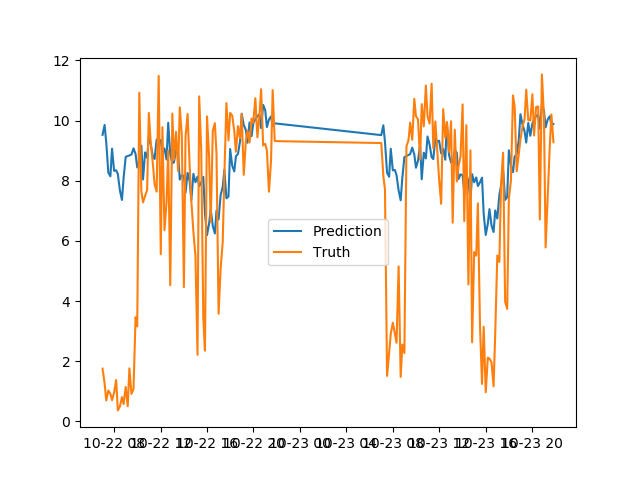

In [61]:
%matplotlib notebook

net.visualize_road(validation,timesteps=6, road=16)